## Forecasting Influenza-Like Illness in Kent County, Michigan

**Lillian Jensen**

Note: this notebook is very messy. To view the polished report, take a look at 'Final Analysis py.ipynb'

---
**Research Question**

Does a county-specific time series model of ILI incidence with local syndromic data, Google search trends data, weather data, and air quality data have a statistically significant improvement on ILI prediction compared to historical trends alone?

**Datasets to be Used**

This analysis uses heterogeneous, multi-source data. Kent County ILI incidence data is from the Michigan Disease Surveillance System (MDSS), ED visits data is from the Michigan Syndromic Surveillance System (MSSS), historical air quality data is from a publicly available EPA database, search term trends come from Google’s Health Trends API, and climate data was sourced from the NOAA Climate Online Data Access.


---
*Setting up code environment*

In [228]:
import pandas as pd
import plotly.express as px
from datetime import datetime
from epiweeks import Week, Year
from calendar import month_name
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as smt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from scipy.stats import chi2_contingency
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

warnings.filterwarnings('ignore')

## Some helpful functions ##

def plot_ccf_sm(target, exog, adjusted=False, nlags=52):
    """Plot CCF using Statsmodels"""
    ccfs = smt.ccf(target, exog, adjusted=False)[:nlags+1]
    lags = np.arange(len(ccfs))[:nlags+1]
    _ = plt.stem(lags, ccfs)
    _ = plt.title(f"Cross Correlations: {target.name} & {exog.name}")
    plt.show()
    plt.close()

def crosscorr(x: pd.Series, y: pd.Series, lag: int=0) -> float:
    """ Lag-N cross correlation. 
    Shifted data (y) filled with NaNs 
    """
    return x.corr(y.shift(lag),)

def difference(dataset, n):
    """ this function intakes a list of values, 
    subtracts the nth prior value,
    and returns the list of differenced values.
    """
    return pd.Series([dataset[i] - dataset[i - n] for i in range(1, len(dataset))])

def ADF(time_series, max_lags):
    """
    Format and print Ad-Fuller test output
    """
    t_stat, p_value, lags, _, critical_values, _ = adfuller(
                                                            time_series,
                                                            maxlag=max_lags
                                                            )
    print(f'ADF Statistic: {t_stat:.2f}')
    print(f'p-value: {p_value:.2f}')
    print(f'lags: {lags}')
    for key, value in critical_values.items():
        print('Critial Values:')
        print(f'   {key}, {value:.2f}')
        
def means_by_month_make_pretty(df_means: pd.DataFrame) -> pd.DataFrame:
        df = df_means.apply(lambda x: round(x,3))
        df = df.reset_index().rename(columns={'Month':'Variable'}).set_index('Variable')
        df = df.rename(columns=pretty_var_names)
        df = df.T
        return df

def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                                "coeff":coeff,
                                "conf_lower":conf_lower,
                                "conf_higher":conf_higher
                                })
    #Reordering...
    results_df = results_df[["coeff","pvals","conf_lower","conf_higher"]]
    return results_df


pretty_var_names = {
                    'cases'             :   'Cases',
                    'ed_visits'         :   'EDVisits',
                    'wind'              :   'Wind',
                    'precip'            :   'Precip (in)',
                    'snow'              :   'Snow (in)',
                    'temp'              :   'Temp (F)',
                    'aqi'               :   'AQI',
                    'flu_ggl_searches'  :   "Flu GS",
                    'cough_ggl_searches':   "Cough GS",
                    'cold_ggl_searches' :   "Cold GS",
                    'co'                :   'CO',
                    'ozone'             :   'Ozone',
                    'pm10'              :   'PM10',
                    'pm25'              :   'PM2.5',
                    'no2'               :   'NO2',
                    'year'              :   'Year',
                    'top'               :   'Main Poll'
                    }

cont_vars = [
            'Cases', 'EDVisits', 'Wind', 'Precip (in)', 
            'Snow (in)', 'Temp (F)', 'AQI', 'CO', 'Ozone',
            'PM10', 'PM2.5', 'NO2', "Flu GS", 
            "Cough GS", "Cold GS"
            ]

months_ordered = [
                'January', 'February', 'March', 
                'April', 'May', 'June', 'July', 
                'August', 'September', 'October', 
                'November', 'December'
                ]

cases_variables = ['Cases','EDVisits']
weather_variables = ['Wind','Precip (in)','Snow (in)','Temp (F)']
air_quality_variables = ['AQI', 'CO', 'Ozone', 'PM10', 'PM2.5','NO2']
google_variables = ["Flu GS","Cough GS","Cold GS"]

In [229]:
df = pd.read_csv('data.csv', index_col=0)
df = df.rename(columns=pretty_var_names)

---
Continuous measurements of pollutants is problematic

In [ ]:
fig = px.line(df.set_index('weekstart')['NO2'])
fig.update_layout(autosize=False,width=1200,height=400)
fig.show('png')

In [ ]:
fig = px.line(df.set_index('weekstart')['Ozone'])
fig.update_layout(autosize=False,width=1200,height=400)
fig.show('png')

In [ ]:
fig = px.line(df.set_index('weekstart')['PM2.5'])
fig.update_layout(autosize=False,width=1200,height=400)
fig.show('png')

In [ ]:
fig = px.line(df.set_index('weekstart')['PM10'])
fig.update_layout(autosize=False,width=1200,height=400)
fig.show('png')

In [ ]:
fig = px.line(df.set_index('weekstart')['CO'])
fig.update_layout(autosize=False,width=1200,height=400)
fig.show('png')

---
ILI Cases zero-inflation problem?

In [ ]:
fig = px.histogram(df['Cases'], )
fig.update_yaxes(title='freq')
fig.update_xaxes(title='ILI Cases')
fig.update_layout(autosize=False,width=1200,height=400, title='All-Month ILI Cases')
fig.show()

---
Monthly means will be calculated for each continuous variable alongside violin plots to visualize variable spreads. 

In [230]:
df_cont_vars_and_month = df.set_index('weekstart')[cont_vars+['Month']]
df_monthly_means = df_cont_vars_and_month.groupby('Month').mean()
df_monthly_means = df_monthly_means.apply(lambda x: round(x))

pretty_means = means_by_month_make_pretty(df_monthly_means)
pretty_means = pretty_means[months_ordered]

#"""for var in [cases_variables,weather_variables,google_variables,air_quality_variables]:
#   print(tabulate(pretty_means.T[var].T, headers=['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']))
# #  print('')"""


In [231]:
s = scaled_df[cont_vars]
s['Month'] = df.set_index('weekstart')['Month']
s = s.groupby('Month').mean().apply(lambda x: round(x, 3))

In [232]:
d = s.reset_index().rename(columns={'Month':'Variable'}).set_index('Variable').T[months_ordered].reset_index().melt(id_vars='index').rename(columns={'index':'Variable','Variable':'Month'})

In [233]:
d

,Variable,Month,value
0,Cases,January,0.822
1,EDVisits,January,0.520
2,Wind,January,0.523
3,Precip (in),January,-0.179
4,Snow (in),January,1.245
...,...,...,...
175,PM2.5,December,0.672
176,NO2,December,0.078
177,Flu GS,December,0.053
178,Cough GS,December,0.775


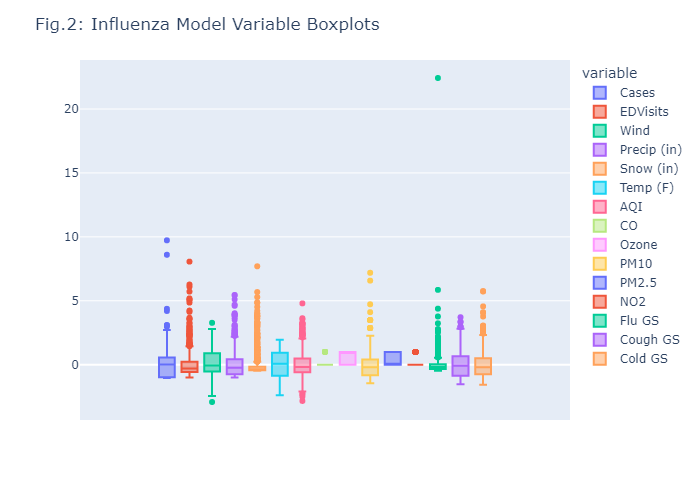

In [234]:
fig = px.box(scaled_df.reset_index()[cont_vars].melt(),y='value', color='variable')
fig.update_layout(title='Fig.2: Influenza Model Variable Boxplots')
fig.update_yaxes(title='',)
fig.show('png')

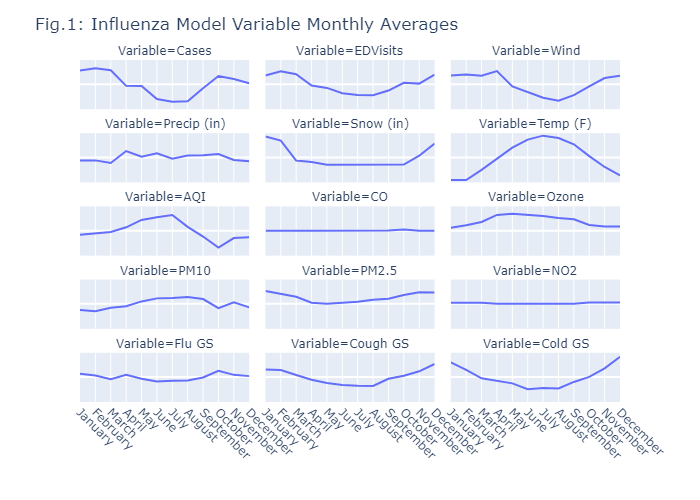

In [235]:
fig = px.line(d, x='Month',y='value',facet_col='Variable',facet_col_wrap=3, facet_col_spacing=0.03)
fig.update_layout(title='Fig.1: Influenza Model Variable Monthly Averages')
fig.update_xaxes(categoryorder='array', categoryarray=months_ordered,title='',tickangle=45)
fig.update_yaxes(title='', tickvals = ['','',''])
fig.show('png')

In [10]:
#pretty_means.to_csv('pretty means .csv')

In [ ]:
for var in cont_vars:
    fig = px.violin(df_cont_vars_and_month, x = 'Month', y = var, title=f'{var} by Month')
    fig.update_xaxes(categoryorder='array', categoryarray=months_ordered, tickvals=None)
    fig.update_layout(autosize=False,width=1200,height=400)
    fig.show('png')

---
Associations between month and main pollutant will be explored with Chi2 test of association and visualized with a stacked bar chart. 


In [237]:
df_month_pollutant = df[['Month','Main Poll']]

In [238]:
df_month_dummy_pollutant = pd.get_dummies(df_month_pollutant.set_index('Main Poll')['Month']).reset_index()
month_pollutant_freq = df_month_dummy_pollutant.groupby('Main Poll').sum()[months_ordered]
print(tabulate(month_pollutant_freq.T, headers=month_pollutant_freq.T.columns))

             CO    NO2    Ozone    PM2.5
---------  ----  -----  -------  -------
January       0      4       11       47
February      1      3       18       34
March         0      4       32       26
April         0      0       57        4
May           0      0       61        0
June          0      0       56        4
July          0      0       56        8
August        0      0       49       16
September     1      0       44       20
October       4      5       22       35
November      0      4       16       44
December      0      5       16       43


In [239]:
stat, p, dof, expected = chi2_contingency(month_pollutant_freq)

print(f"Chisq         : {stat}")
print(f"p-value       : {p}")
print(f"Deg. Freedom  : {dof}")


Chisq         : 304.13808250339616
p-value       : 1.2884077202528089e-45
Deg. Freedom  : 33


In [23]:
#pd.DataFrame([304, '<0.001', 33],['Chisq','p-value','Deg. Freedom']).to_csv('chisq.csv')

In [240]:
melted_month_pollutant_freq = month_pollutant_freq.reset_index()
melted_month_pollutant_freq = melted_month_pollutant_freq.melt(
                                                                id_vars='Main Poll',
                                                                value_vars=months_ordered, 
                                                                var_name='Month',
                                                                value_name='freq'
                                                                )

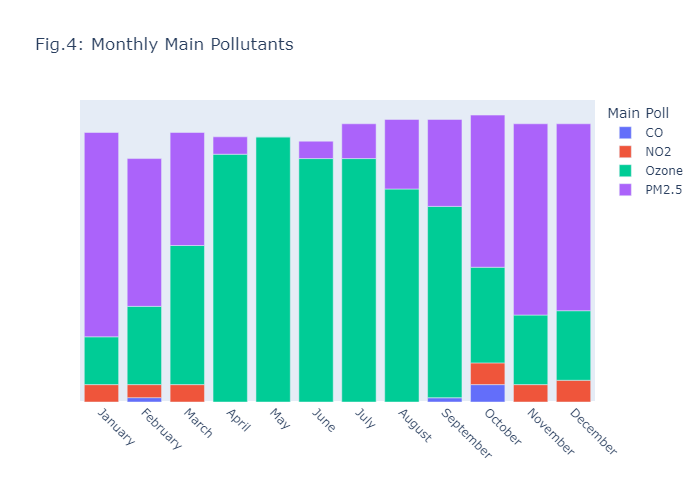

In [241]:
fig = px.bar(melted_month_pollutant_freq, x='Month',y='freq', color='Main Poll', title='Fig.4: Monthly Main Pollutants')
#fig.update_layout(autosize=False,width=1200,height=400)
fig.update_xaxes(title='',tickangle=45)
fig.update_yaxes(title='',tickvals=['','','',''])
fig.show('png')

---
Continuous variables’ multicollinearity will be assessed with Pearson correlation and Variance Inflation Factors


In [242]:
scaler = preprocessing.StandardScaler()
scaled_df = df.set_index('weekstart')[cont_vars]
scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df),columns=scaled_df.columns,index=scaled_df.index)
poll_dummies = pd.get_dummies(df.set_index('weekstart')['Main Poll'])
scaled_df[poll_dummies.columns] = poll_dummies[poll_dummies.columns]
scaled_df[[f'month_{m}' for m in range(1,13)]] = df.set_index('weekstart')[[f'month_{m}' for m in range(1,13)]]

In [243]:

corr_matrix = scaled_df[cont_vars].corr()
pvals = scaled_df[cont_vars].corr(method=lambda x,y: pearsonr(x,y,)[1]) - np.eye(*corr_matrix.shape)
p = pvals.applymap(lambda x: ''.join(['*' for t in [.05,.01,.001] if x<=t]))
corr_matrix_sigs = corr_matrix[cont_vars].round(2).astype(str) + p
corr_matrix_sigs

,Cases,EDVisits,Wind,Precip (in),Snow (in),Temp (F),AQI,CO,Ozone,PM10,PM2.5,NO2,Flu GS,Cough GS,Cold GS
Cases,1.0***,0.58***,0.29***,-0.04,0.22***,-0.57***,-0.29***,0.01,-0.28***,-0.18***,0.24***,0.09*,0.27***,0.17***,0.23***
EDVisits,0.58***,1.0***,0.24***,-0.01,0.17***,-0.43***,-0.26***,-0.04,-0.11**,-0.21***,0.15***,-0.09*,0.33***,0.59***,0.45***
Wind,0.29***,0.24***,1.0***,0.2***,0.3***,-0.5***,-0.28***,0.02,-0.12**,-0.23***,0.08*,0.1**,0.07*,0.23***,0.3***
Precip (in),-0.04,-0.01,0.2***,1.0***,0.03,0.13***,-0.17***,-0.03,0.07,-0.17***,-0.06,-0.02,0.12**,-0.01,-0.03
Snow (in),0.22***,0.17***,0.3***,0.03,1.0***,-0.58***,-0.14***,-0.02,-0.29***,-0.19***,0.28***,0.05,0.03,0.18***,0.41***
Temp (F),-0.57***,-0.43***,-0.5***,0.13***,-0.58***,1.0***,0.35***,-0.01,0.47***,0.28***,-0.43***,-0.14***,-0.12**,-0.37***,-0.56***
AQI,-0.29***,-0.26***,-0.28***,-0.17***,-0.14***,0.35***,1.0***,-0.19***,0.14***,0.43***,-0.06,-0.12**,-0.18***,-0.31***,-0.34***
CO,0.01,-0.04,0.02,-0.03,-0.02,-0.01,-0.19***,1.0***,-0.11**,-0.0,-0.07,-0.02,-0.0,-0.08*,-0.07*
Ozone,-0.28***,-0.11**,-0.12**,0.07,-0.29***,0.47***,0.14***,-0.11**,1.0***,0.02,-0.92***,-0.22***,-0.01,-0.14***,-0.24***
PM10,-0.18***,-0.21***,-0.23***,-0.17***,-0.19***,0.28***,0.43***,-0.0,0.02,1.0***,-0.04,0.07,-0.12***,-0.22***,-0.25***


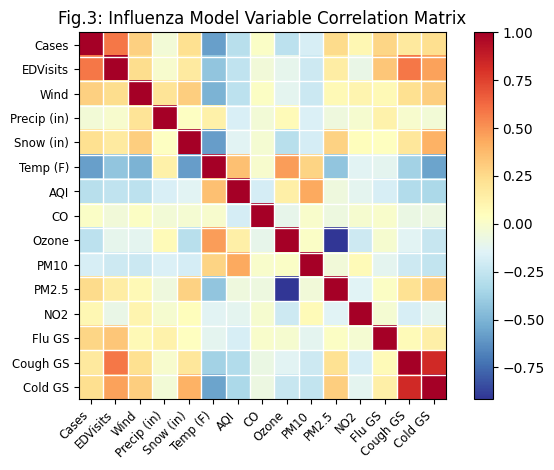

In [244]:
sm.graphics.plot_corr(scaled_df[cont_vars].corr(), xnames=cont_vars, title='Fig.3: Influenza Model Variable Correlation Matrix').show()

In [245]:
corr_matrix = scaled_df[cont_vars].corr()
#corr_matrix.style.background_gradient(cmap='RdBu_r').format(precision=2).to_html('test.html')

In [246]:
vif = pd.DataFrame()
vif['variable'] = scaled_df[cont_vars].columns
vif['VIF'] = [variance_inflation_factor(scaled_df[cont_vars].values,i) for i in range(len(cont_vars))]
#vif.to_csv('vif.csv')

In [247]:
print(tabulate(vif, headers=vif.columns))

    variable         VIF
--  -----------  -------
 0  Cases        2.29917
 1  EDVisits     2.87311
 2  Wind         1.5433
 3  Precip (in)  1.25201
 4  Snow (in)    1.71599
 5  Temp (F)     3.88875
 6  AQI          1.6181
 7  CO           1.08142
 8  Ozone        1.1533
 9  PM10         1.34005
10  PM2.5        1.20432
11  NO2          1.14465
12  Flu GS       1.26075
13  Cough GS     5.4652
14  Cold GS      5.19432


---
ILI cases will be modeled with months alone and with months + other variables to explore the impact of the other variables on cases.


In [248]:
## Months Model ##

x = sm.add_constant(scaled_df[[f'month_{m}' for m in range(1,13) if m != 6]])
y = scaled_df['Cases']
mod = sm.OLS(endog=y, exog=x, hasconst=True).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     56.85
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           9.40e-91
Time:                        16:57:05   Log-Likelihood:                -834.05
No. Observations:                 750   AIC:                             1692.
Df Residuals:                     738   BIC:                             1748.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8779      0.096     -9.168      0.000      -1.066      -0.690
month_1        1.7001      0.134     12.658      0.000       1.436       1.964
month_2        1.8326      0.138     13.298      0.000       1.562       2.103
month_3        1.7107      0.134     12.736      0.000       1.447       1.974
month_4        0.7844      0.135      5.817      0.000       0.520       1.049
month_5        0.7736      0.135      5.736      0.000       0.509       1.038
month_7       -0.1576      0.133     -1.182      0.237      -0.419       0.104
month_8       -0.1313      0.133     -0.989      0.323      -0.392       0.129
month_9        0.6406      0.133      4.824      0.000       0.380       0.901
month_10       1.3668      0.132     10.331      0.000       1.107       1.627
month_11       1.1871      0.133      8.907      0.000       0.925       1.449
month_12       0.9384      0.133      7.041      0.000       0.677       1.200
==============================================================================
Omnibus:                      835.680   Durbin-Watson:                   0.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            95336.797
Skew:                           5.124   Prob(JB):                         0.00
Kurtosis:                      57.275   Cond. No.                         13.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [249]:
results_summary_to_dataframe(mod).apply(lambda x: round(x,3))\
    .T.rename(columns={num:name for num,name in zip([f'month_{x}' for x in range(1,13)],months_ordered)}).T\
#.to_csv('1mod1.csv')

,coeff,pvals,conf_lower,conf_higher
const,-0.878,0.000,-1.066,-0.690
January,1.700,0.000,1.436,1.964
February,1.833,0.000,1.562,2.103
March,1.711,0.000,1.447,1.974
April,0.784,0.000,0.520,1.049
May,0.774,0.000,0.509,1.038
July,-0.158,0.237,-0.419,0.104
August,-0.131,0.323,-0.392,0.129
September,0.641,0.000,0.380,0.901
October,1.367,0.000,1.107,1.627


In [312]:
## Months and Variables Model ##

x = sm.add_constant(scaled_df.drop(columns=['Cases','month_6']))
y = scaled_df['Cases']
mod = sm.OLS(endog=y, exog=x, hasconst=True).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     53.32
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          2.39e-142
Time:                        18:20:23   Log-Likelihood:                -682.82
No. Observations:                 750   AIC:                             1416.
Df Residuals:                     725   BIC:                             1531.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.5140      0.108     -4.738      0.000      -0.727      -0.301
EDVisits        0.5383      0.034     15.960      0.000       0.472       0.605
Wind           -0.0339      0.030     -1.138      0.255      -0.092       0.025
Precip (in)     0.0203      0.025      0.802      0.423      -0.029       0.070
Snow (in)      -0.0394      0.031     -1.263      0.207      -0.101       0.022
Temp (F)       -0.1283      0.073     -1.756      0.080      -0.272       0.015
AQI            -0.0649      0.033     -1.972      0.049      -0.130      -0.000
CO             -0.4049      0.211     -1.917      0.056      -0.819       0.010
Ozone          -0.0660      0.070     -0.941      0.347      -0.204       0.072
PM10            0.0317      0.026      1.198      0.231      -0.020       0.084
PM2.5          -0.0025      0.074     -0.033      0.973      -0.147       0.143
NO2            -0.0406      0.119     -0.340      0.734      -0.275       0.194
Flu GS          0.0300      0.025      1.188      0.235      -0.020       0.080
Cough GS       -0.3823      0.052     -7.389      0.000      -0.484      -0.281
Cold GS         0.0704      0.054      1.309      0.191      -0.035       0.176
month_1         1.0728      0.200      5.366      0.000       0.680       1.465
month_2         1.1016      0.203      5.434      0.000       0.704       1.500
month_3         1.0467      0.173      6.044      0.000       0.707       1.387
month_4         0.4883      0.141      3.472      0.001       0.212       0.764
month_5         0.5762      0.117      4.910      0.000       0.346       0.807
month_7        -0.0929      0.112     -0.828      0.408      -0.313       0.127
month_8        -0.1467      0.114     -1.285      0.199      -0.371       0.077
month_9         0.5374      0.118      4.559      0.000       0.306       0.769
month_10        0.9529      0.141      6.774      0.000       0.677       1.229
month_11        0.8282      0.163      5.084      0.000       0.508       1.148
month_12        0.3932      0.188      2.094      0.037       0.025       0.762
==============================================================================
Omnibus:                      267.563   Durbin-Watson:                   1.377
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5810.097
Skew:                           1.066   Prob(JB):                         0.00
Kurtosis:                      16.468   Cond. No.                     3.97e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.73e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [314]:
import math

In [320]:
mod.predict().apply(lambda x: x in range(0.95*scaled_df['Cases'],1.05*scaled_df['Cases']))

AttributeError: 'numpy.ndarray' object has no attribute 'apply'

In [319]:
mod.predict() == range(0.95*scaled_df['Cases'],1.05*scaled_df['Cases'])

TypeError: 'Series' object cannot be interpreted as an integer

In [325]:
pd.Series(scaled_df['Cases'] / mod.predict()).loc[pd.Series((scaled_df['Cases'] / mod.predict())*10).isin(range(-5,5))]

Series([], Name: Cases, dtype: float64)

In [251]:
results_summary_to_dataframe(mod).apply(lambda x: round(x,3))\
    .T.rename(columns={num:name for num,name in zip([f'month_{x}' for x in range(1,13)],months_ordered)}).T\
#.to_csv('1mod2.csv')

,coeff,pvals,conf_lower,conf_higher
const,-0.514,0.000,-0.727,-0.301
EDVisits,0.538,0.000,0.472,0.605
Wind,-0.034,0.255,-0.092,0.025
Precip (in),0.020,0.423,-0.029,0.070
Snow (in),-0.039,0.207,-0.101,0.022
Temp (F),-0.128,0.080,-0.272,0.015
AQI,-0.065,0.049,-0.130,-0.000
CO,-0.405,0.056,-0.819,0.010
Ozone,-0.066,0.347,-0.204,0.072
PM10,0.032,0.231,-0.020,0.084


---
The stationarity of ILI cases will be tested using the Adfuller Test of Stationarity. If the series fails to show stationarity, another Adfuller test will be performed on the first-differenced data.


In [252]:
cases_series = scaled_df[['Cases']]

In [253]:
#pd.DataFrame([['ADF','p-value','Lags'],[-2.29,0.17,51],[-11.78,0.00,50]]).T.set_index(0).rename(columns={1:'Cases',2:'First Difference'}).T.to_csv('adf.csv')

In [254]:
#pd.DataFrame([['ADF','p-value','Lags'],[-2.29,0.17,51],[-11.78,0.00,50]]).T.set_index(0).rename(columns={1:'Cases',2:'First Difference'}).T

In [255]:
ADF(cases_series, 52)

ADF Statistic: -2.29
p-value: 0.17
lags: 51
Critial Values:
   1%, -3.44
Critial Values:
   5%, -2.87
Critial Values:
   10%, -2.57


In [256]:
ADF(difference(cases_series['Cases'],1),52)

ADF Statistic: -11.78
p-value: 0.00
lags: 50
Critial Values:
   1%, -3.44
Critial Values:
   5%, -2.87
Critial Values:
   10%, -2.57


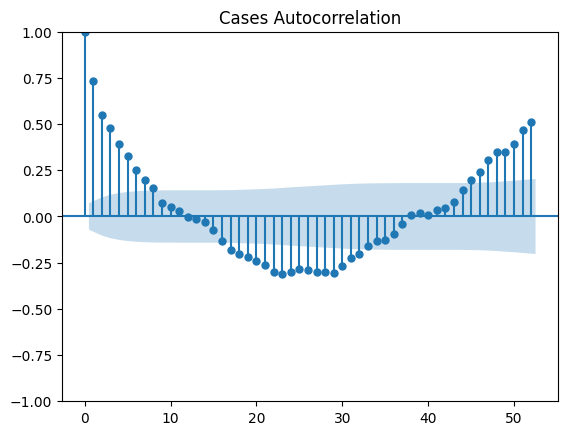

In [258]:
plot_acf(cases_series, lags = 52, title='Cases Autocorrelation', ).show()

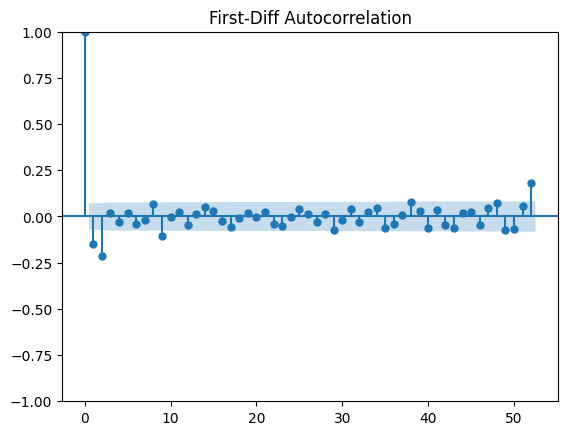

In [259]:
plot = plot_acf(difference(cases_series['Cases'],1), lags = 52, title='First-Diff Autocorrelation')

---
If the cases series or its first-differenced transformation are indeed stationary, an autoregression model will be developed to explore any lagged-effects of past weeks in the data.


In [260]:
cases_series.index = pd.to_datetime(cases_series.index)
cases_series = cases_series.resample('W').first()
cases_series['Cases'] = cases_series['Cases'].fillna(method='ffill')

cases_series_preds = cases_series.copy()

                            AutoReg Model Results                             
Dep. Variable:                  Cases   No. Observations:                  752
Model:                    AutoReg(52)   Log Likelihood                -653.568
Method:               Conditional MLE   S.D. of innovations              0.616
Date:                Wed, 13 Dec 2023   AIC                           1415.135
Time:                        19:16:44   BIC                           1660.894
Sample:                    07-30-2006   HQIC                          1510.136
                         - 12-22-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0055      0.023      0.235      0.814      -0.040       0.051
Cases.L1       0.6468      0.037     17.334      0.000       0.574       0.720
Cases.L2      -0.1449      0.045     -3.247      0.0

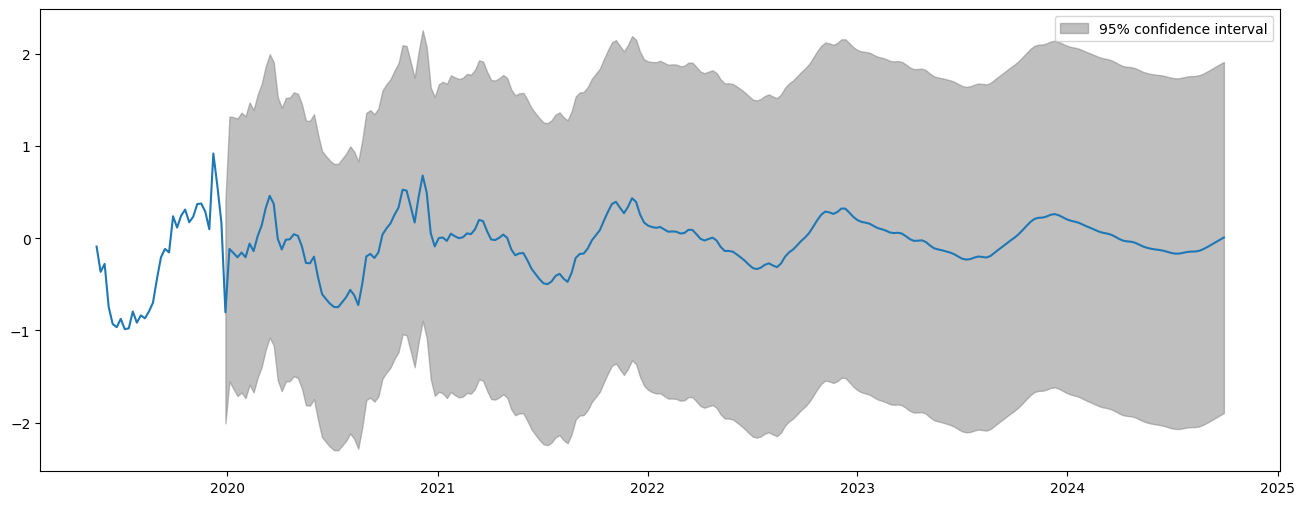

In [335]:
mod = AutoReg(cases_series, 52)
res = mod.fit()
print(res.summary())

#cases_series_preds['Nonseasonal'] = res.predict()
fig = res.plot_predict(720, 1000, figsize=(16, 6))



In [262]:
#results_summary_to_dataframe(mod).apply(lambda x: round(x,3)).to_csv('1mod3.csv')

                            AutoReg Model Results                             
Dep. Variable:                  Cases   No. Observations:                  752
Model:              Seas. AutoReg(52)   Log Likelihood                -592.012
Method:               Conditional MLE   S.D. of innovations              0.564
Date:                Wed, 13 Dec 2023   AIC                           1394.025
Time:                        19:16:58   BIC                           1871.888
Sample:                    07-30-2006   HQIC                          1578.747
                         - 12-22-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4760      0.191     -2.494      0.013      -0.850      -0.102
s(2,52)       -0.0690      0.225     -0.306      0.759      -0.511       0.373
s(3,52)       -0.0586      0.239     -0.245      0.8

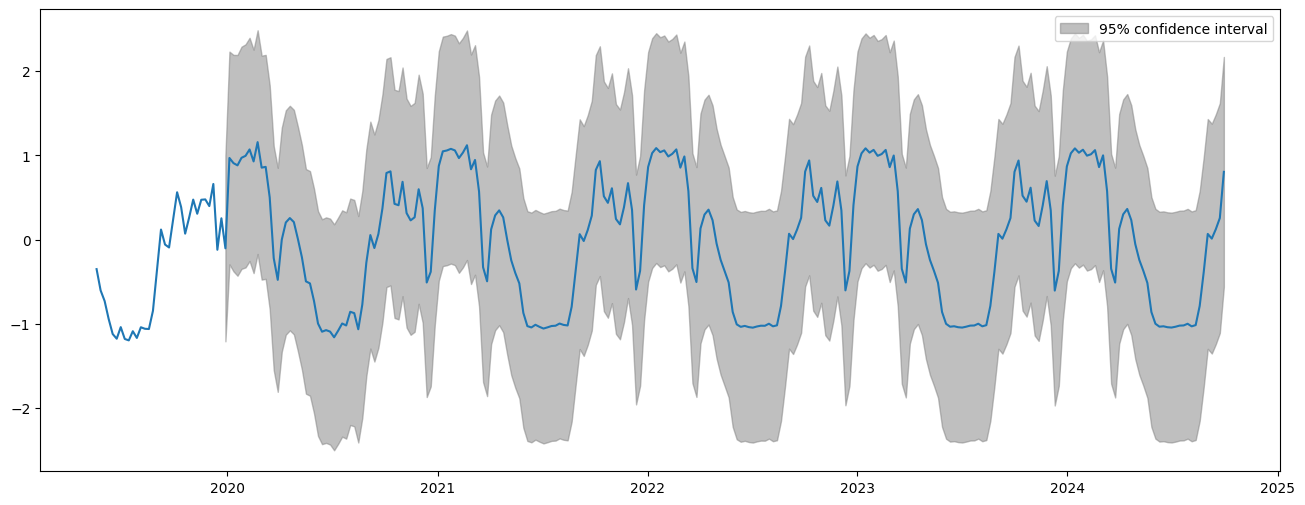

In [336]:
mod = AutoReg(cases_series, seasonal=True, lags=52)
res = mod.fit()
print(res.summary())

#cases_series_preds['Seasonal'] = res.predict()

fig = res.plot_predict(720, 1000, figsize=(16, 6))


In [264]:
#results_summary_to_dataframe(mod).apply(lambda x: round(x,3)).to_csv('1mod4.csv')

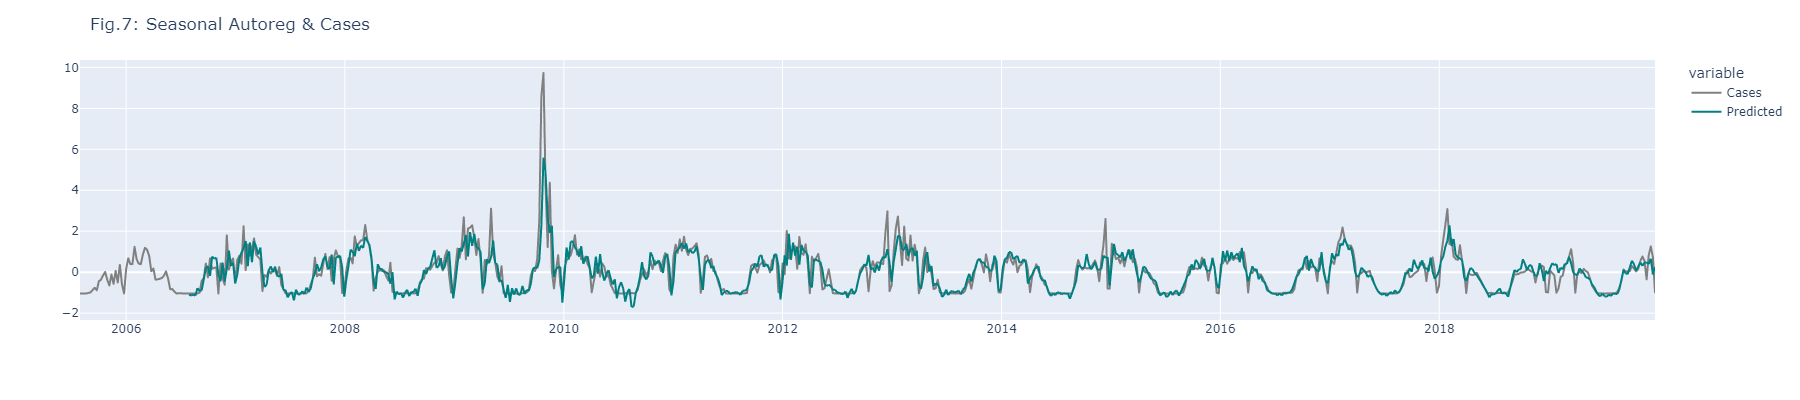

Median predictive accuracy: 92%


In [280]:
fig = px.line(cases_series_preds[['Cases','Predicted']], color_discrete_map={'Cases':'grey','Predicted':'teal'})
fig.update_layout(autosize=False,width=1800,height=400, title='Fig.7: Seasonal Autoreg & Cases')
fig.update_xaxes(title='')
fig.update_yaxes(title='')
fig.show('png')

print(75*'=')
print('Median predictive accuracy: ' + str(round(cases_series_preds['seasonal autoreg accuracy (%)'].median())) + '%')
print(75*'=')

In [ ]:
fig = px.line(d, x='Month',y='value',facet_col='Variable',facet_col_wrap=3, facet_col_spacing=0.03)
fig.update_layout(title='Fig.1: Influenza Model Variable Monthly Averages')
fig.update_xaxes(categoryorder='array', categoryarray=months_ordered,title='',tickangle=45)
fig.update_yaxes(title='', tickvals = ['','',''])
fig.show('png')

In [300]:
series_preds_melted = cases_series_preds[['Cases','Nonseasonal','Seasonal']].reset_index().melt(id_vars='weekstart',var_name='Series').set_index('weekstart')

In [301]:
series_preds_melted

,Series,value
weekstart,,
2005-07-31,Cases,-1.040778
2005-08-07,Cases,-1.040778
2005-08-14,Cases,-1.040778
2005-08-21,Cases,-1.039695
2005-08-28,Cases,-1.015864
...,...,...
2019-11-24,Seasonal,0.476683
2019-12-01,Seasonal,0.397324
2019-12-08,Seasonal,0.659919


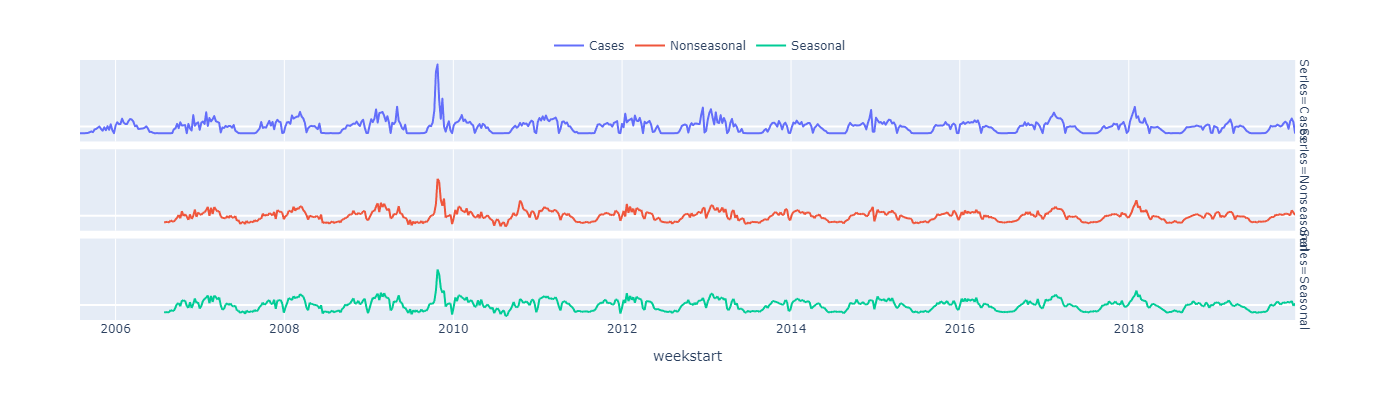

In [308]:
fig=px.line(series_preds_melted,facet_row='Series',color='Series')
fig.update_layout(autosize=False,width=1400,height=400, title='', 
                    legend=dict(
                                title=None, orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"
    ))

fig.update_yaxes(title='', tickvals=['','',''])

fig.show('png')

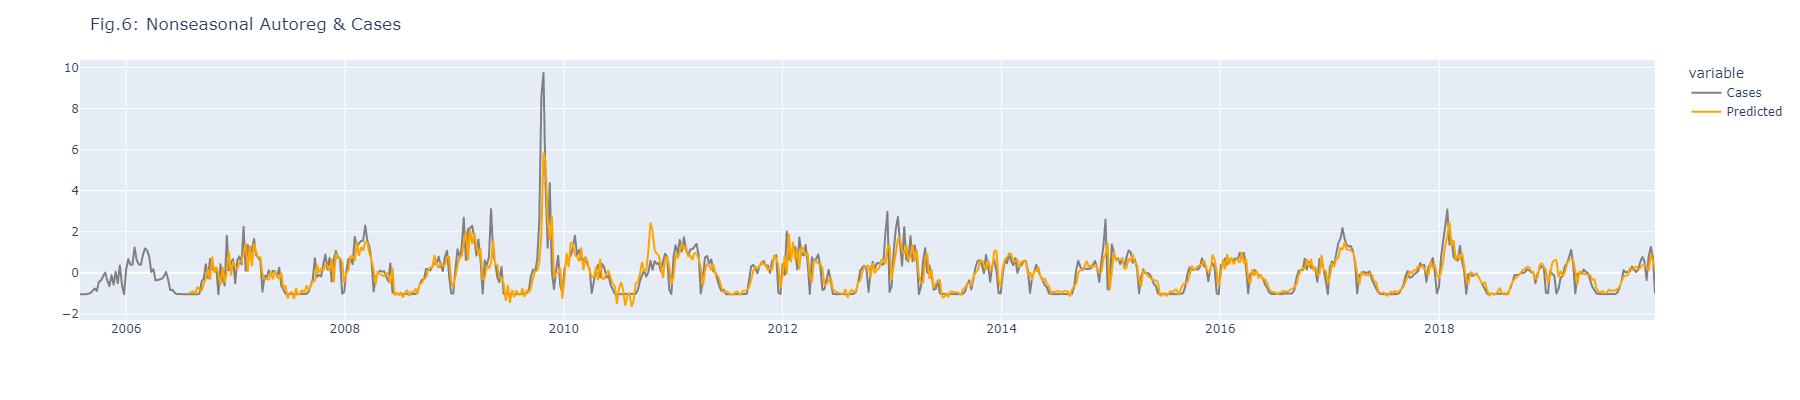

Median predictive accuracy: 82%


In [278]:
fig=px.line(cases_series_preds[['Cases','Predicted']], color_discrete_map={'Predicted':'orange','Cases':'grey'})
fig.update_layout(autosize=False,width=1800,height=400, title='Fig.6: Nonseasonal Autoreg & Cases')
fig.update_xaxes(title='')
fig.update_yaxes(title='')
fig.show('png')

print(75*'=')
print('Median predictive accuracy: ' + str(round(cases_series_preds['autoreg accuracy (%)'].median())) + '%')
print(75*'=')

** The autoregression models are overfitted **

---
Delayed-effects of independent variables on ILI cases will be explored with cross-correlation plots to select lagged terms which may have an influence on cases. 


In [30]:
ind_cont_vars = [v for v in cont_vars if v != 'Cases']

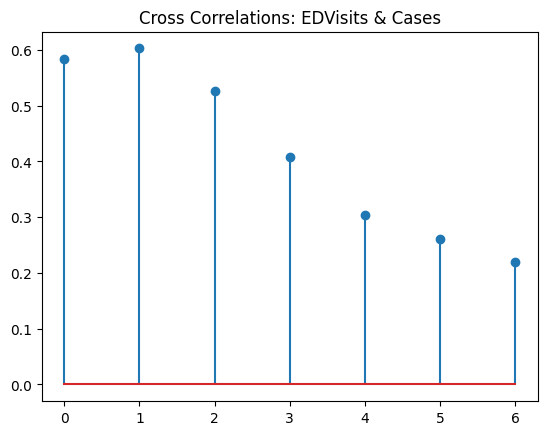

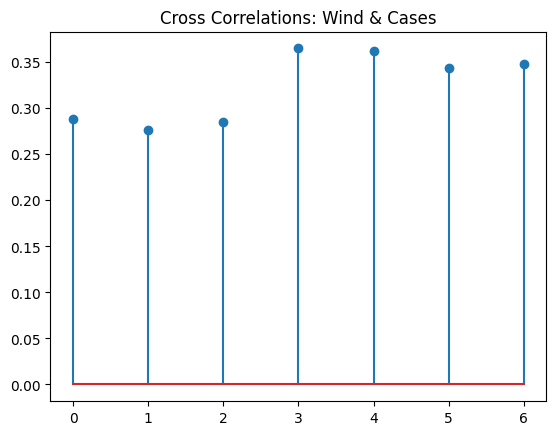

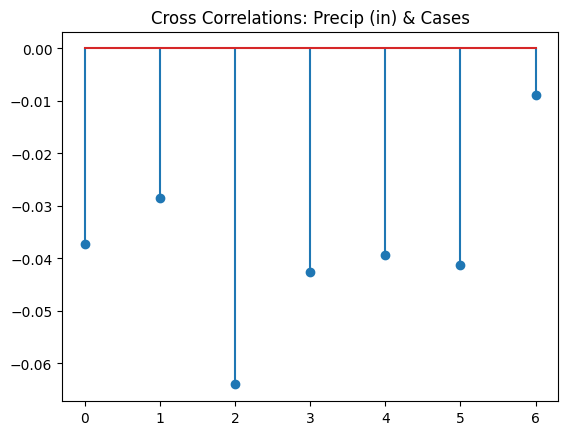

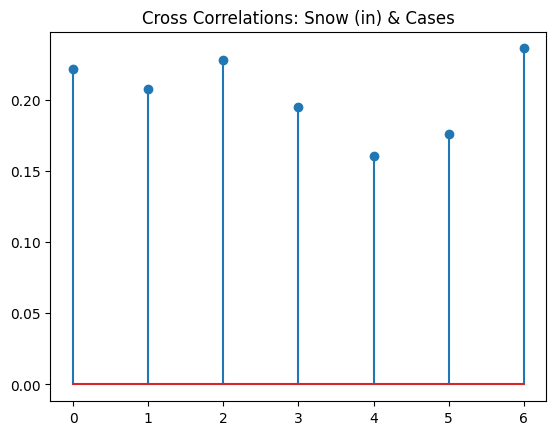

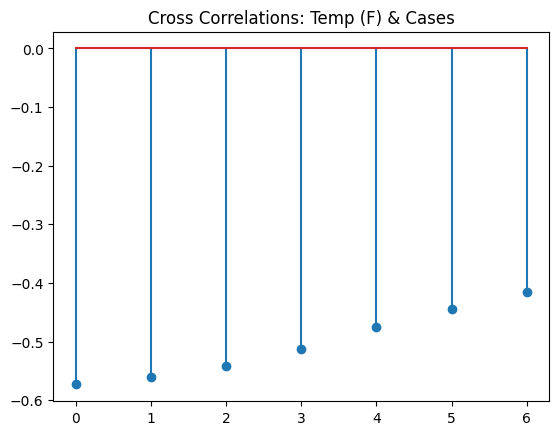

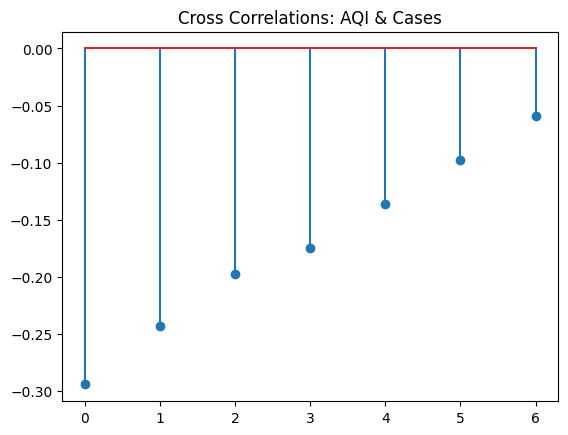

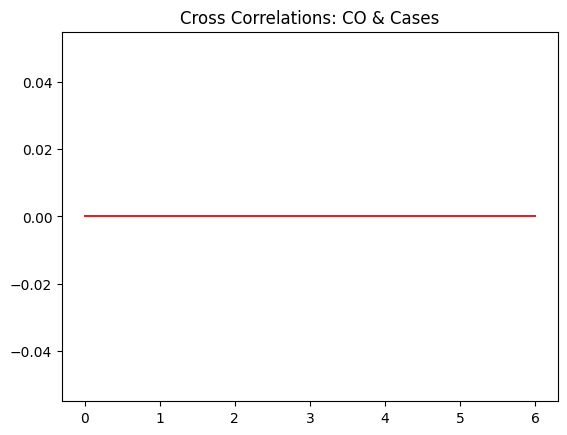

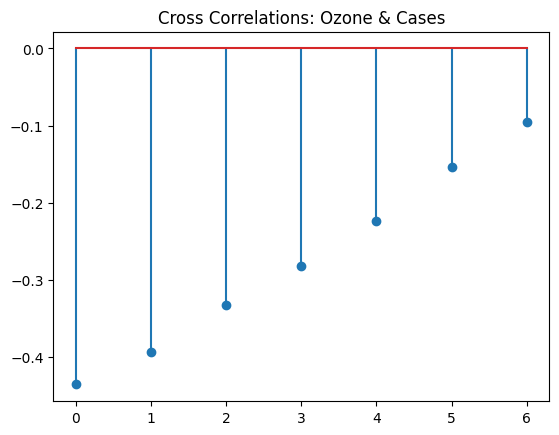

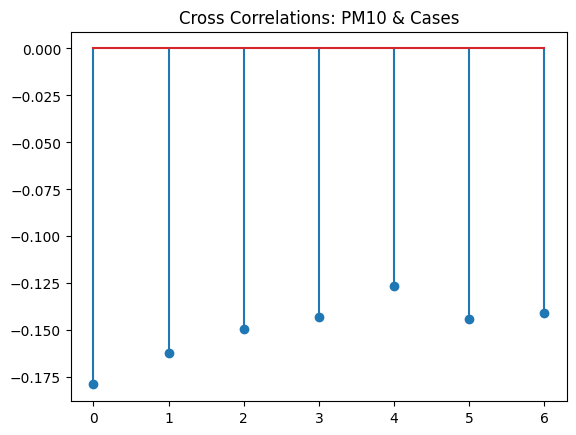

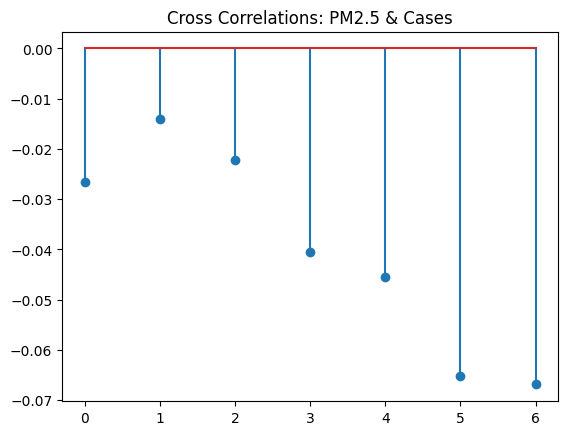

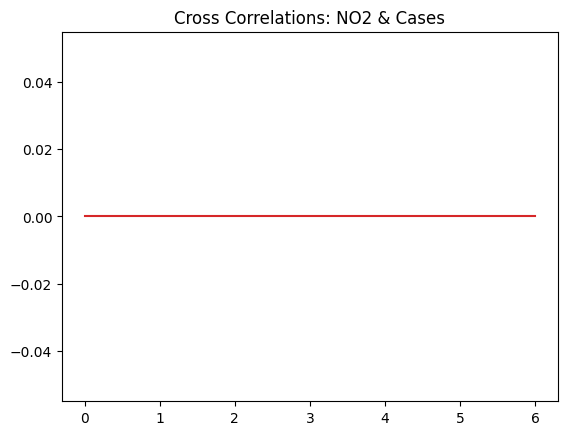

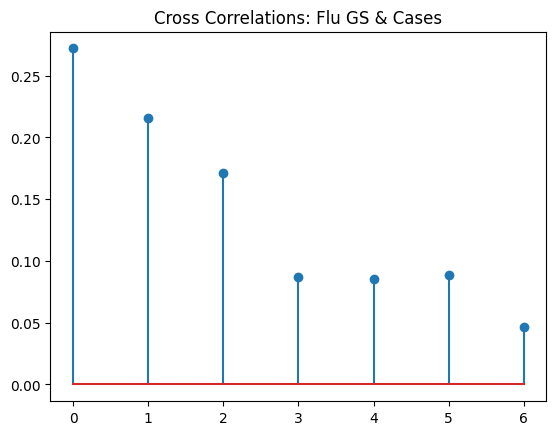

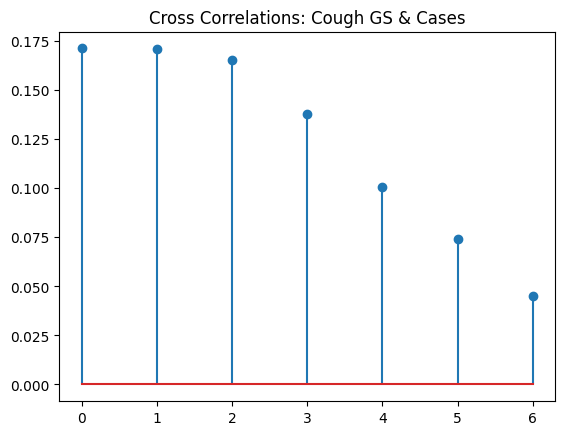

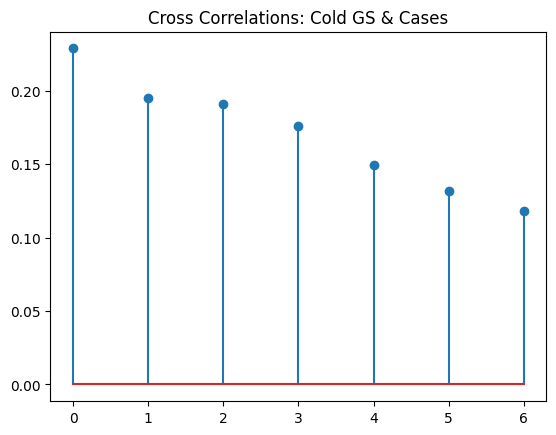

In [37]:
for v in ind_cont_vars:
    plot_ccf_sm(df[v], df['Cases'],nlags=6)
    


---
These lagged terms will be included in a multiple linear regression model, alongside auto-lags, months, and other terms


...how would one go about doing this?

In [ ]:
mod = 

In [44]:
scaled_df

,Cases,EDVisits,Wind,Precip (in),Snow (in),Temp (F),AQI,CO,Ozone,PM10,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Month
weekstart,,,,,,,,,,,,,,,,,,,,,
7/31/2005,-1.040778,-0.925096,-0.537451,-0.914502,-0.434716,1.322372,3.300493,0,1,2.872571,...,0,0,0,1,0,0,0,0,0,NaN
8/7/2005,-1.040778,-1.011771,-1.013914,-0.245354,-0.434716,1.369410,3.051637,0,0,2.872571,...,0,0,0,0,1,0,0,0,0,NaN
8/14/2005,-1.040778,-0.910650,-1.013914,-0.245354,-0.434716,1.169774,1.309646,0,0,0.406139,...,0,0,0,0,1,0,0,0,0,NaN
8/21/2005,-1.039695,-0.968434,-1.013914,-0.747215,-0.434716,0.939510,0.065366,0,1,3.489178,...,0,0,0,0,1,0,0,0,0,NaN
8/28/2005,-1.015864,-0.896204,-0.537451,-0.747215,-0.434716,1.048899,-0.515298,0,1,-0.210469,...,0,0,0,0,1,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11/24/2019,-0.349695,2.238555,0.891939,0.925654,-0.434716,-0.646633,-1.013010,0,1,-0.827077,...,0,0,0,0,0,0,0,1,0,NaN
12/1/2019,0.824496,2.541919,-0.060987,0.089220,0.967876,-0.920106,-1.510721,0,0,-1.443685,...,0,0,0,0,0,0,0,0,1,NaN
12/8/2019,1.256693,2.917513,0.891939,-0.245354,0.266580,-0.974800,-0.764154,0,0,-1.443685,...,0,0,0,0,0,0,0,0,1,NaN


In [45]:
df

,weekstart,Cases,EDVisits,Wind,Precip (in),Snow (in),Temp (F),AQI,CO,Ozone,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Main Poll,Month
0,7/31/2005,0,8,8,0.01,0.00,74.00,84,5.0,83,...,0,0,1,0,0,0,0,0,Ozone,July
1,8/7/2005,0,2,7,0.09,0.00,74.86,81,6.0,75,...,0,0,0,1,0,0,0,0,PM2.5,August
2,8/14/2005,0,9,7,0.09,0.00,71.21,60,6.0,43,...,0,0,0,1,0,0,0,0,PM2.5,August
3,8/21/2005,1,5,7,0.03,0.00,67.00,45,4.0,42,...,0,0,0,1,0,0,0,0,Ozone,August
4,8/28/2005,23,10,8,0.03,0.00,69.00,38,6.0,38,...,0,0,0,1,0,0,0,0,Ozone,August
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,11/24/2019,638,227,11,0.23,0.00,38.00,32,7.0,20,...,0,0,0,0,0,0,1,0,Ozone,November
746,12/1/2019,1722,248,9,0.13,0.64,33.00,26,8.0,24,...,0,0,0,0,0,0,0,1,PM2.5,December
747,12/8/2019,2121,274,11,0.09,0.32,32.00,35,9.0,18,...,0,0,0,0,0,0,0,1,PM2.5,December
748,12/15/2019,1638,319,9,0.02,0.46,27.00,40,6.0,5,...,0,0,0,0,0,0,0,1,PM2.5,December


In [46]:
d = scaled_df[cont_vars]
d['Month'] = df.set_index('weekstart')['Month']

In [50]:
d = pd.melt(d.reset_index(), value_vars=cont_vars, id_vars=['weekstart','Month'])

In [ ]:
    fig.update_xaxes(categoryorder='array', categoryarray=months_ordered)
cases_variables = ['Cases','EDVisits']
weather_variables = ['Wind','Precip (in)','Snow (in)','Temp (F)']
air_quality_variables = ['AQI', 'CO', 'Ozone', 'PM10', 'PM2.5','NO2']
google_variables = ["Flu GS","Cough GS","Cold GS"]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [57]:
'Cases' in cases_variables

True

In [72]:
all_variables = cases_variables + weather_variables + air_quality_variables + google_variables

In [73]:
all_variables

['Cases',
 'EDVisits',
 'Wind',
 'Precip (in)',
 'Snow (in)',
 'Temp (F)',
 'AQI',
 'CO',
 'Ozone',
 'PM10',
 'PM2.5',
 'NO2',
 'Flu GS',
 'Cough GS',
 'Cold GS']

In [74]:
d

,weekstart,Month,variable,value
0,7/31/2005,July,Cases,-1.040778
1,8/7/2005,August,Cases,-1.040778
2,8/14/2005,August,Cases,-1.040778
3,8/21/2005,August,Cases,-1.039695
4,8/28/2005,August,Cases,-1.015864
...,...,...,...,...
11245,11/24/2019,November,Cold GS,1.702582
11246,12/1/2019,December,Cold GS,2.298165
11247,12/8/2019,December,Cold GS,1.937537
11248,12/15/2019,December,Cold GS,2.445694


In [99]:
fig = px.box(d, x='variable',y='value')
fig.update_layout(title=)
fig.update_xaxes(title='Variable')
fig.update_yaxes(title='Scaled Continuous Variables')
fig.show('png')

SyntaxError: invalid syntax (874876195.py, line 2)

In [90]:
scaled_df

,Cases,EDVisits,Wind,Precip (in),Snow (in),Temp (F),AQI,CO,Ozone,PM10,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Month
weekstart,,,,,,,,,,,,,,,,,,,,,
7/31/2005,-1.040778,-0.925096,-0.537451,-0.914502,-0.434716,1.322372,3.300493,0,1,2.872571,...,0,0,0,1,0,0,0,0,0,NaN
8/7/2005,-1.040778,-1.011771,-1.013914,-0.245354,-0.434716,1.369410,3.051637,0,0,2.872571,...,0,0,0,0,1,0,0,0,0,NaN
8/14/2005,-1.040778,-0.910650,-1.013914,-0.245354,-0.434716,1.169774,1.309646,0,0,0.406139,...,0,0,0,0,1,0,0,0,0,NaN
8/21/2005,-1.039695,-0.968434,-1.013914,-0.747215,-0.434716,0.939510,0.065366,0,1,3.489178,...,0,0,0,0,1,0,0,0,0,NaN
8/28/2005,-1.015864,-0.896204,-0.537451,-0.747215,-0.434716,1.048899,-0.515298,0,1,-0.210469,...,0,0,0,0,1,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11/24/2019,-0.349695,2.238555,0.891939,0.925654,-0.434716,-0.646633,-1.013010,0,1,-0.827077,...,0,0,0,0,0,0,0,1,0,NaN
12/1/2019,0.824496,2.541919,-0.060987,0.089220,0.967876,-0.920106,-1.510721,0,0,-1.443685,...,0,0,0,0,0,0,0,0,1,NaN
12/8/2019,1.256693,2.917513,0.891939,-0.245354,0.266580,-0.974800,-0.764154,0,0,-1.443685,...,0,0,0,0,0,0,0,0,1,NaN


In [91]:
for s in [all_variables]:
    fig = px.violin(scaled_df, x=s, y='Cases')
    fig.show()
    fig.close()
    

AttributeError: 'Figure' object has no attribute 'close'

In [70]:
for s in [cases_variables, weather_variables, air_quality_variables, google_variables]:
    fig = px.box(d.loc[d['variable'].isin(s)], x='Month', y='value', color='variable')
    fig.update_xaxes(categoryorder='array',categoryarray=months_ordered)
    fig.show()

In [59]:
'Cases' in cases_variables

True

In [61]:
cases_variables

['Cases', 'EDVisits']

In [60]:
d

,weekstart,Month,variable,value
0,7/31/2005,July,Cases,-1.040778
1,8/7/2005,August,Cases,-1.040778
2,8/14/2005,August,Cases,-1.040778
3,8/21/2005,August,Cases,-1.039695
4,8/28/2005,August,Cases,-1.015864
...,...,...,...,...
11245,11/24/2019,November,Cold GS,1.702582
11246,12/1/2019,December,Cold GS,2.298165
11247,12/8/2019,December,Cold GS,1.937537
11248,12/15/2019,December,Cold GS,2.445694


In [68]:
d.loc[(d['variable'].isin(cases_variables))]

,weekstart,Month,variable,value
0,7/31/2005,July,Cases,-1.040778
1,8/7/2005,August,Cases,-1.040778
2,8/14/2005,August,Cases,-1.040778
3,8/21/2005,August,Cases,-1.039695
4,8/28/2005,August,Cases,-1.015864
...,...,...,...,...
1495,11/24/2019,November,EDVisits,2.238555
1496,12/1/2019,December,EDVisits,2.541919
1497,12/8/2019,December,EDVisits,2.917513
1498,12/15/2019,December,EDVisits,3.567578


In [64]:
d['variable']

0          Cases
1          Cases
2          Cases
3          Cases
4          Cases
          ...   
11245    Cold GS
11246    Cold GS
11247    Cold GS
11248    Cold GS
11249    Cold GS
Name: variable, Length: 11250, dtype: object

In [66]:
d.loc[(d['variable']=='Cases') | (d['variable'] =='EDVisits')]

,weekstart,Month,variable,value
0,7/31/2005,July,Cases,-1.040778
1,8/7/2005,August,Cases,-1.040778
2,8/14/2005,August,Cases,-1.040778
3,8/21/2005,August,Cases,-1.039695
4,8/28/2005,August,Cases,-1.015864
...,...,...,...,...
1495,11/24/2019,November,EDVisits,2.238555
1496,12/1/2019,December,EDVisits,2.541919
1497,12/8/2019,December,EDVisits,2.917513
1498,12/15/2019,December,EDVisits,3.567578


In [109]:
t = ds.Table.from_df(vif)

In [113]:
%matplotlib inline

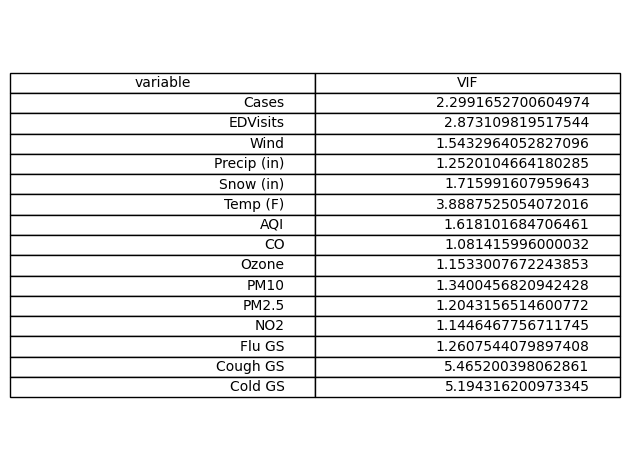

In [114]:
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=vif.values, colLabels=vif.columns, loc='center')
fig.tight_layout()
plt.show()

In [117]:
corr_matrix_sigs.to_markdown('mark down .md')

In [118]:
corr_matrix_sigs.to_latex('latex .html')

In [ ]:
Table 4: Model Fits
	Months-Only	All-Variables
R-squared:	0.459	0.638
Adj. R-squared:	0.451	0.626
F-statistic:	57	53
Prob (F-statistic):	0	0
Log-Likelihood:	-834	-682
AIC:	1692	1416
BIC:	1748	1531


In [286]:
pd.read_clipboard().T.reset_index().T.set_index(0).rename(columns={1:'Months-Only',2:'All-Variables'}).to_csv('fits.csv')

In [309]:
df

,weekstart,Cases,EDVisits,Wind,Precip (in),Snow (in),Temp (F),AQI,CO,Ozone,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Main Poll,Month
0,7/31/2005,0,8,8,0.01,0.00,74.00,84,5.0,83,...,0,0,1,0,0,0,0,0,Ozone,July
1,8/7/2005,0,2,7,0.09,0.00,74.86,81,6.0,75,...,0,0,0,1,0,0,0,0,PM2.5,August
2,8/14/2005,0,9,7,0.09,0.00,71.21,60,6.0,43,...,0,0,0,1,0,0,0,0,PM2.5,August
3,8/21/2005,1,5,7,0.03,0.00,67.00,45,4.0,42,...,0,0,0,1,0,0,0,0,Ozone,August
4,8/28/2005,23,10,8,0.03,0.00,69.00,38,6.0,38,...,0,0,0,1,0,0,0,0,Ozone,August
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,11/24/2019,638,227,11,0.23,0.00,38.00,32,7.0,20,...,0,0,0,0,0,0,1,0,Ozone,November
746,12/1/2019,1722,248,9,0.13,0.64,33.00,26,8.0,24,...,0,0,0,0,0,0,0,1,PM2.5,December
747,12/8/2019,2121,274,11,0.09,0.32,32.00,35,9.0,18,...,0,0,0,0,0,0,0,1,PM2.5,December
748,12/15/2019,1638,319,9,0.02,0.46,27.00,40,6.0,5,...,0,0,0,0,0,0,0,1,PM2.5,December


In [310]:
df['Cases'].sum()

720626

In [311]:
df['EDVisits'].sum()

54029